In [ ]:
# Loading the cleaned data set
%store -r data

# Imports

import pandas as pd
from sklearn.model_selection import train_test_split

# Parallelisation
from joblib import parallel_backend

# evaluation
from sklearn import metrics
import matplotlib.pyplot as plt

# Data
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Model Imports
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, Embedding, Flatten, \
                            Dropout, Activation
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant

# Convolutional Neural Network (CNN)

In [131]:
# Subsetting the data to get 1,000,000 observations
data = data.sample(n = 1000000)

### Data Pre-Processing 

In [195]:
# Tokenizing and Sequence Padding for training data

MAX_SEQUENCE_LENGTH = 50
MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

features = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data['target']))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', features.shape)
print('Shape of label tensor:', labels.shape)

# Train and test split

TRAIN_SPLIT = 0.2
indices  = np.arange(features.shape[0])
np.random.shuffle(indices)
features = features[indices]
labels   = labels[indices]
num_test_samples = int(TRAIN_SPLIT * features.shape[0])
x_train = features[:-num_test_samples]
y_train = labels[:-num_test_samples]
x_testing   = features[-num_test_samples:]
y_testing   = labels[-num_test_samples:]

# Test and validation split

VALIDATION_SPLIT = 0.5
indices  = np.arange(x_testing.shape[0])
np.random.shuffle(indices)
x_testing = x_testing[indices]
y_testing   = y_testing[indices]
num_val_samples = int(VALIDATION_SPLIT * x_testing.shape[0])
x_test = x_testing[:-num_val_samples]
y_test = y_testing[:-num_val_samples]
x_val   = x_testing[-num_val_samples:]
y_val   = y_testing[-num_val_samples:]


Found 403697 unique tokens.
Shape of data tensor: (1581466, 50)
Shape of label tensor: (1581466, 2)


### Creating Embedding Matrix

In [197]:
# Generating embedding index from Glove text file

embeddings_index = {}

# opening the downloaded glove embeddings file
f = open('glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word   = value = values[0]
    coefs  = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [198]:
# Creating embedding matrix

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Building the model

In [199]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,trainable=False, weights = [embedding_matrix])
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 3, activation='relu')(embedded_sequences)
x = Conv1D(32, 3, activation='relu')(x)
x = Conv1D(16, 3, activation='relu')(x)

x = GlobalMaxPooling1D()(x)

x = Flatten()(x)

x = Dropout(0.2)(x)
x = Dense(180, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='relu')(x)

output = Activation('sigmoid')(x)

model = Model(inputs=[sequence_input], outputs=[output])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_25 (Embedding)    (None, 50, 300)           3000000   
                                                                 
 conv1d_72 (Conv1D)          (None, 48, 64)            57664     
                                                                 
 conv1d_73 (Conv1D)          (None, 46, 32)            6176      
                                                                 
 conv1d_74 (Conv1D)          (None, 44, 16)            1552      
                                                                 
 global_max_pooling1d_24 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                          

### Training the model

In [200]:
with parallel_backend('threading'):
    history = model.fit(x_train, y_train,batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1236/1236 [==============================] - ETA: 0s - loss: 0.5289 - acc: 0.7341WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff5f6055830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

KeyboardInterrupt: 

### Evaluating the model

In [ ]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [194]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

evaluate(y_test, y_pred, 'Convolutional Neural Network')

3125/3125 [==============================] - 11s 3ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

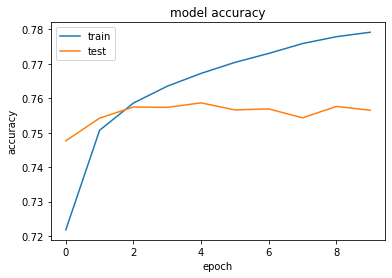

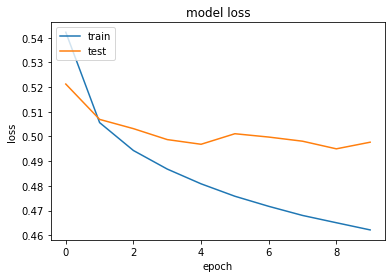

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Exporting Model

In [180]:
model.save("group144_pretrained_model", save_format="h5")